In [2]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
from torch import nn

In [3]:
def show_original_img(img):
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(np.uint8(img))

    # Display the image using matplotlib
    plt.title("Original Image")
    plt.imshow(img_pil, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()

In [4]:
def show_image_with_edges(img, upper_edge_row_vals, lower_edge_row_vals, interval):
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(np.uint8(img))

    # Create a copy of the image to avoid modifying the original
    img_with_edges = img_pil.copy()

    # Calculate x and y coordinates for the points
    x_coords_up = np.arange(0, len(upper_edge_row_vals) * interval, interval)
    y_coords_up = upper_edge_row_vals
    x_coords_low = np.arange(0, len(lower_edge_row_vals) * interval, interval)
    y_coords_low = lower_edge_row_vals

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image on the axis
    ax.set_title("Image with edges")  # Set the title for the axis
    ax.imshow(img_with_edges, cmap='gray')

    # Plot the points on the image in red color
    ax.scatter(x_coords_up, y_coords_up, color='red', s=2)  # 's' is the marker size
    ax.scatter(x_coords_low, y_coords_low, color='yellow', s=2)  # 's' is the marker size

    # Hide axes
    ax.axis('off')

    # Show the plot
    plt.show()

In [6]:
def joint_edges_values(img, interval, image_size=224):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint8:
        raise ValueError("Image must be a NumPy array of type uint8")
    if interval <= 0 or not isinstance(interval, int):
        raise ValueError("Interval must be a positive integer")

    # col_indices hold indices of columns at specific intervals along image row/width
    col_indices = np.arange(0, image_size, interval)
    # initialize upper row values to 1/3rd of image height
    upper_edge_rvals = np.full(len(col_indices), int(image_size/4), dtype=np.uint8)
    # initialize lower row values to 3/4th of image height
    lower_edge_rvals = np.full(len(col_indices), int(image_size*3/4), dtype=np.uint8)

    for i, c in enumerate(col_indices):
        up_start, low_start = int(image_size/4), int(image_size*3/4)
        col = img[:, c]
        col = col[up_start:low_start]
        col_max, col_min, col_std = col.max(), col.min(), col.std()
        col_thresh = col_min + int(col_std) # improvement
        
        up_flag = low_flag = False

        upper_r, lower_r = up_start, low_start
        while upper_r < lower_r:
            if not up_flag:
                # need to improve
                if img[upper_r, c] < col_thresh and img[upper_r+1, c] < col_thresh and img[upper_r+2, c] < col_thresh:
                    upper_edge_rvals[i] = upper_r
                    up_flag = True
                else:
                    upper_r += 1
                
            if not low_flag:
                if img[lower_r, c] < col_thresh and img[lower_r-1, c] < col_thresh and img[lower_r-2, c] < col_thresh:
                    lower_edge_rvals[i] = lower_r
                    low_flag = True
                else:
                    lower_r -= 1
            
            if up_flag and low_flag:
                break
    
    max_dist = int(up_start/2)
    for i in range(len(col_indices)):
        if (lower_edge_rvals[i] - upper_edge_rvals[i]) > max_dist:
            upper_edge_rvals[i] = lower_edge_rvals[i]
        
    return upper_edge_rvals, lower_edge_rvals

## Sobel Operator

In [10]:
def power_law_transformation(image, gamma=1.0, constant=1):
    # Build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 * constant
                      for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def preprocess(img):
    gamma_corrected = power_law_transformation(img, 7.0,1)
    return gamma_corrected
#     blurred = cv2.GaussianBlur(image, (5, 5), 0)
#     equalized = cv2.equalizeHist(blurred)
    return equalized

def sobelOperator(img, threshold=200):
    container = np.copy(img)
    size = container.shape
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            gx = (img[i - 1][j - 1] + 2*img[i][j - 1] + img[i + 1][j - 1]) - (img[i - 1][j + 1] + 2*img[i][j + 1] + img[i + 1][j + 1])
            gy = (img[i - 1][j - 1] + 2*img[i - 1][j] + img[i - 1][j + 1]) - (img[i + 1][j - 1] + 2*img[i + 1][j] + img[i + 1][j + 1])
            magnitude = min(255,np.sqrt(gx**2 + gy**2))
#             container[i][j] = 255 if magnitude >= threshold else 0
            container[i][j] = magnitude
    return container

def np_img_to_tensor(img):
    if len(img.shape) == 2:
        img = img[..., np.newaxis]
    img_tensor = torch.from_numpy(img)
    img_tensor = img_tensor.permute(2, 0, 1)
    img_tensor = torch.unsqueeze(img_tensor, 0)
    return img_tensor


def tensor_to_np_img(img_tensor):
    img = img_tensor.cpu().permute(0, 2, 3, 1).numpy()
    return img[0, ...]  # get the first element since it's batch form

def sobel_torch_version(img_np, torch_sobel):
    img_tensor = np_img_to_tensor(np.float32(img_np))
    img_edged = tensor_to_np_img(torch_sobel(img_tensor))
    img_edged = np.squeeze(img_edged)
    return img_edged

class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=False)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def Sobel2(img):
    torch_sobel = Sobel()
    container = np.copy(img)
    container = cv2.resize(container, (224, 224))
#     tik = time.time()
    rgb_edged = sobel_torch_version(container, torch_sobel=torch_sobel)
#     tok = time.time()

#     torch_time = tok-tik

#     tik = time.time()
    rgb_edged_cv2_x = cv2.Sobel(container, cv2.CV_64F, 1, 0, ksize=3)
    rgb_edged_cv2_y = cv2.Sobel(container, cv2.CV_64F, 0, 1, ksize=3)
#     tok = time.time()
    rgb_edged_cv2 = np.sqrt(np.square(rgb_edged_cv2_x), np.square(rgb_edged_cv2_y))
#     cv2_time = tok-tik

#     print(f"torch time: {torch_time}s, cv2 time: {cv2_time}s")

    container = cv2.resize(container, (222, 222))
    rgb_edged_cv2 = cv2.resize(rgb_edged_cv2, (222, 222))
    rgb_both = np.concatenate(
        [container / 255, rgb_edged / np.max(rgb_edged), rgb_edged_cv2 / np.max(rgb_edged_cv2)], axis=1)

    plt.imshow(rgb_both, cmap="gray")
    plt.show()
    return rgb_edged

def show(img,unit=7):
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(np.uint8(img))

    # Create a copy of the image to avoid modifying the original
    img_with_edges = img_pil.copy()

    # Calculate x and y coordinates for the points
    x_coords_up = np.arange(0, 224, unit)
    y_coords_up = upper_edge_row_vals
    x_coords_low = np.arange(0, 224, unit)
    y_coords_low = lower_edge_row_vals

    # Create a figure and axis
    fig, ax = plt.subplots()

    ax.set_title("Image with edges")  # Set the title for the axis
    # Display the image on the axis
    ax.imshow(img_with_edges, cmap="gray")

    # Plot the points on the image in red color
    ax.scatter(x_coords_up, y_coords_up, color='red', s=10)  # 's' is the marker size
    ax.scatter(x_coords_low, y_coords_low, color='blue', s=10)  # 's' is the marker size

    # Hide axes
    ax.axis('off')

    # Show the plot
    plt.show()

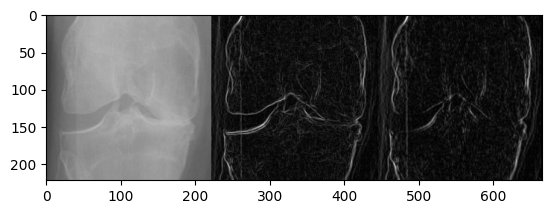

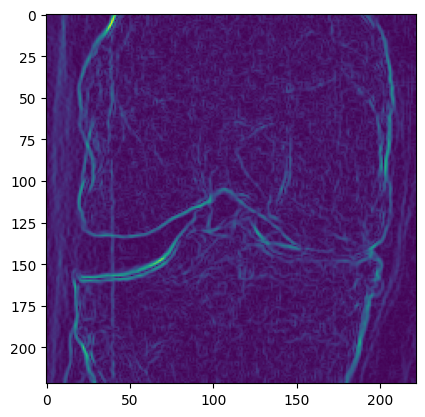

In [13]:
img_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/4/9031426R.png" #"/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/0/9011115R.png"
img = Image.open(img_path)
img = np.array(img)

trials = 1
for i in range(trials):
    img = Sobel2(img)
plt.imshow(img)
plt.show()

# Main Program to show original and edge-detected image

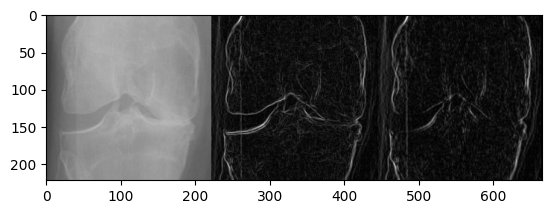

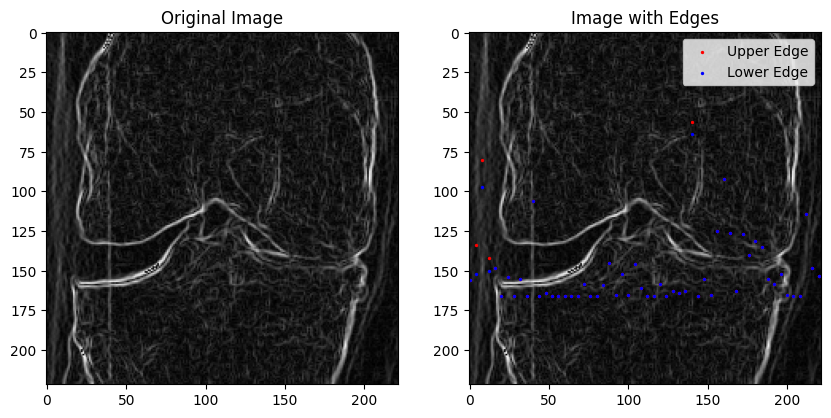



Joint space in pixels taken at an interval of 4 pixels along image width

Total points = 55
[ 0 18 17  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [16]:
# -------- show result for single image ------------
img_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/4/9031426R.png" #"/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/0/9011115R.png"
img = Image.open(img_path)
img = np.array(img)

trials = 1
for i in range(trials):
    img = Sobel2(img)
    
img = np.array(np.uint8(img))

# ------ Define the output folder -------
output_folder = '/kaggle/working/'  # Replace with the actual path to your output folder
os.makedirs(output_folder, exist_ok=True) 

# --- show original image ------
# show_original_img(img)

interval = 4
# calculate upper and lower edges for this image
upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(img, interval, img[0].size)

joint_space_pixel_gap = lower_edge_row_vals - upper_edge_row_vals

# Plotting both images in the same row
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')

# Plot the image with edges
axs[1].imshow(img, cmap='gray')
axs[1].scatter(range(0, img.shape[1], interval), upper_edge_row_vals, color='r', label='Upper Edge', s=2)
axs[1].scatter(range(0, img.shape[1], interval), lower_edge_row_vals, color='b', label='Lower Edge', s=2)
axs[1].set_title('Image with Edges')
axs[1].legend()

plt.show()

# show pixel gaps at specific interval along image-width
print(f"\n\nJoint space in pixels taken at an interval of {interval} pixels along image width\n")
print(f'Total points = {int(img.shape[1]/interval)}')
print(joint_space_pixel_gap)

In [72]:
# ----------- check result for multiple images ----------

# Define the input and output folders
input_folder = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train/"
output_folder = '/kaggle/working/output_folder'  # Replace with the actual path to your output folder
os.makedirs(output_folder, exist_ok=True)

interval = 4
num_images_each_label = 100

# Create an empty DataFrame to store joint space values
columns = ['img_name', 'KL', 'l', 'r']
joint_spaces_df = pd.DataFrame(columns=columns)


# Iterate through each sub-folder
for folder in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder)
    print('Currently processing: ', folder_path)
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # List all png files in the folder
        png_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]

        # Take 100 images randomly or all if there are less than 100
        num_images_to_take = min(num_images_each_label, len(png_files))
        selected_images = random.sample(png_files, num_images_to_take)

        # Create a sub-folder in the output folder for each input sub-folder
        output_subfolder = os.path.join(output_folder, folder)
        os.makedirs(output_subfolder, exist_ok=True)

        # Process each selected image
        for file in selected_images:
            file_path = os.path.join(folder_path, file)
            image = Image.open(file_path)

            # calculate upper and lower edges for this image
            upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(np.array(image), interval, image.size[0])

            # Calculate joint space values
            joint_space_val = lower_edge_row_vals - upper_edge_row_vals

            left_start = 40//interval
            right_start = 150//interval
            left_joint_space = np.mean(joint_space_val[left_start:left_start+20])
            right_joint_space = np.mean(joint_space_val[right_start:right_start+20])
            l = int(left_joint_space)
            r = int(right_joint_space)

          # Save the joint space values to the DataFrame
            file_name, _ = os.path.splitext(file)
            joint_spaces_df.loc[len(joint_spaces_df)] = [file_name, folder, l, r]

            # Plotting both images in the same row
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            # Plot the original image
            axs[0].imshow(image, cmap='gray')
            axs[0].set_title('Original Image')

            # Plot the image with edges
            axs[1].imshow(image, cmap='gray')
            axs[1].scatter(range(0, image.size[0], interval), upper_edge_row_vals, color='r', label='Upper Edge', s=2)
            axs[1].scatter(range(0, image.size[0], interval), lower_edge_row_vals, color='b', label='Lower Edge', s=2)
            
            # Add text annotations for left and right joint space with a white box background
            axs[1].annotate(f'Left  Joint  Space: {l}\nRight Joint Space: {r}', xy=(0.03, 0.92), xycoords='axes fraction',
                            ha='left', va='center', color='r', bbox=dict(facecolor='white', alpha=0.7, edgecolor='white'))


            axs[1].set_title('Image with Edges')
            axs[1].legend()

            # Save the plot in the sub-folder
            output_path = os.path.join(output_subfolder, f'result_plot_{file}')
            plt.savefig(output_path)
            plt.close()  # Close the plot to avoid multiple plots in the same figure

# Save the joint spaces DataFrame to a CSV file
joint_spaces_df.to_csv('/kaggle/working/joint_spaces.csv', index=False)

print('Saved csv file. Finished Processing ', num_images_each_label*5, 'images.')

Currently processing:  /kaggle/input/knee-osteoarthritis-dataset-with-severity/train/2
Currently processing:  /kaggle/input/knee-osteoarthritis-dataset-with-severity/train/0
Currently processing:  /kaggle/input/knee-osteoarthritis-dataset-with-severity/train/3
Currently processing:  /kaggle/input/knee-osteoarthritis-dataset-with-severity/train/1
Currently processing:  /kaggle/input/knee-osteoarthritis-dataset-with-severity/train/4
Saved csv file. Finished Processing  500 images.


In [73]:
import shutil

shutil.make_archive("/kaggle/working/output_folder", 'zip', "/kaggle/working/output_folder")

'/kaggle/working/output_folder.zip'

In [71]:
!rm -r /kaggle/working/output_folder
!rm /kaggle/working/output_folder.zip
!rm /kaggle/working/joint_spaces.csv

rm: cannot remove '/kaggle/working/output_folder.zip': No such file or directory
